# DJF_PR_teleconnection: Structure of Boreal Winter Precipitation Anomalies

The "DJF_PR_teleconnection" notebook evaluates the relationship between ENSO (El Niño-Southern Oscillation) and boreal winter precipitation anomalies, focusing on the region between 60°S and 60°N. It analyses the spatial and temporal structure of precipitation patterns during the DJF period, providing insights into teleconnections and their potential impacts on global climate variability.

## Recommended Observational Datasets

### Temperature Surface (TS)

- **ERSSTv5**: The Extended Reconstructed Sea Surface Temperature version 5 (ERSSTv5) is a global monthly sea surface temperature dataset derived from in situ observations and optimally interpolated. It is widely used for climate studies and trend analysis.

- **HadISSTv1.1**: The Hadley Centre Sea Ice and Sea Surface Temperature dataset version 1.1 (HadISSTv1.1) provides a globally complete dataset of monthly mean sea surface temperatures and sea ice concentrations since 1870.

- **COBE2**: The Centennial In Situ Observation-Based Estimates version 2 (COBE2) provides high-resolution sea surface temperature data, constructed using historical ship-based observations and modern quality control techniques.

## Precipitation (PR)

- **GPCP**: The Global Precipitation Climatology Project (GPCP) dataset combines satellite and ground-based observations to produce global monthly precipitation estimates with near-global coverage since 1979.

- **CMAP**: The CPC Merged Analysis of Precipitation (CMAP) integrates satellite and gauge-based observations to estimate global precipitation, providing valuable insights into climate variability and hydrological processes.

## Dask Cluster 
Start a cluster with multiple cores

In [1]:
from dask.distributed import Client, progress
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 2,Total memory: 7.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42775,Workers: 2
Dashboard: /proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 7.00 GiB
Comm: tcp://127.0.0.1:34519,Total threads: 1
Dashboard: /proxy/32957/status,Memory: 3.50 GiB
Nanny: tcp://127.0.0.1:35337,


## Datasets

In [2]:
from esmvalcore.dataset import Dataset

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/esmvalcore/config/_config_object.py:639: ESMValCoreDeprecationWarning: Usage of the single configuration file ~/.esmvaltool/config-user.yml or specifying it via CLI argument `--config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please run `mkdir -p ~/.config/esmvaltool && mv /home/189/fc6164/.esmvaltool/config-user.yml ~/.config/esmvaltool` (or alternatively use a custom `--config_dir`) and omit `--config_file`.
  config_obj.reload()
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remov

In [3]:
model_ts_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

model_pr_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='pr',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20150101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}


obs_ts_datasets = {
"HadISST": 
    Dataset(
    short_name='ts',
    dataset='HadISST',
    mip="Amon",
    project='OBS',
    type='reanaly',
    tier=2),
# "ERSSTv5":
#     Dataset(
#     short_name='tos',
#     dataset='NOAA-ERSSTv5',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     tier=2)
}

obs_pr_datasets = {
"GPCP-SG": 
    Dataset(
    short_name='pr',
    dataset='GPCP-SG',
    mip="Amon",
    project='OBS',
    type='atmos',
    tier=2),
# "CMAP": 
#     Dataset(
#     short_name='pr',
#     dataset='CMAP',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     timerange="197901/202408",
#     tier=2)
}

## Add Ancillary files


In [4]:
for name, dataset in model_pr_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")
for name, dataset in model_ts_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [5]:
model_ts_datasets = {name: dataset.load() for name, dataset in model_ts_datasets.items()}
model_pr_datasets = {name: dataset.load() for name, dataset in model_pr_datasets.items()}

obs_ts_datasets = {name: dataset.load() for name, dataset in obs_ts_datasets.items()}
obs_pr_datasets = {name: dataset.load() for name, dataset in obs_pr_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remove_version, more_info)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remove_version, more_info)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/esmvalcore/config/_config_validato

In [6]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import annual_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np


In [25]:
def sst_enso(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1979, end_year=2014, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land") #shp or land fraction
    cube = anomalies(cube, period="monthly")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_region(cube, **nino34_latext_region)
    # cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = area_statistics(cube,operator='mean')
    cube = extract_season(cube, season="DJF")
    cube = annual_statistics(cube, operator='mean')
    
    return cube


def pr_global(cube):
    region = {"start_longitude": 0., "end_longitude": 360., "start_latitude": -60., "end_latitude": 60.}
    cube = extract_time(cube, start_year=1979, end_year=2014, start_month=1, end_month=12, start_day=1, end_day=31)
    cube = convert_units(cube, units="mm/day")
    cube = anomalies(cube, period="monthly")
    cube = detrend(cube, dimension="time", method="linear")
    cube = extract_season(cube, season="DJF")
    cube = annual_statistics(cube, operator='mean')
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **region)
    
    return cube   

In [26]:
model_ts_datasets_prep = {name: sst_enso(dataset) for name, dataset in model_ts_datasets.items()}
model_pr_datasets_prep = {name: pr_global(dataset) for name, dataset in model_pr_datasets.items()}

obs_ts_datasets_prep = {name: sst_enso(dataset) for name, dataset in obs_ts_datasets.items()}
obs_pr_datasets_prep = {name: pr_global(dataset) for name, dataset in obs_pr_datasets.items()}

## Calculate Linear regression

In [8]:
def lin_regress_matrix(cubeA, cubeB):
    """
    Calculate the linear regression of cubeA on cubeB using matrix operations.

    Parameters
    ----------
    cubeA: iris.cube.Cube
        The 2D input cube for which the regression is calculated.
    
    cubeB: iris.cube.Cube
        The cube used as the independent variable in the regression.

    Returns
    -------
    iris.cube.Cube
        A new cube containing the slope of the regression for each spatial point.
    """
    # Get data as flattened arrays
    A_data = cubeA.data.reshape(cubeA.shape[0], -1)  # Shape (time, spatial_points)
    B_data = cubeB.data.flatten()  # Shape (time,)

    # Add intercept term by stacking a column of ones with cubeB
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T

    # Solve the linear equations using least squares method
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)
    
    # Extract slopes from coefficients
    slopes = coefs[0].reshape(cubeA.shape[1], cubeA.shape[2])

    # Create a new Iris Cube for the regression results
    result_cube = iris.cube.Cube(slopes, long_name='regression ENSO SSTA',
                                 dim_coords_and_dims=[(cubeA.coord('latitude'), 0),
                                                      (cubeA.coord('longitude'), 1)])

    return result_cube

In [27]:
reg2_mod = lin_regress_matrix(model_pr_datasets_prep["ACCESS-ESM1-5"], model_ts_datasets_prep["ACCESS-ESM1-5"])
reg2_obs = lin_regress_matrix(obs_pr_datasets_prep["GPCP-SG"], obs_ts_datasets_prep["HadISST"])

process = {"ACCESS-ESM1-5":reg2_mod , "HadISST":reg2_obs} 

In [28]:
print(obs_pr_datasets_prep["GPCP-SG"].data.min(), obs_ts_datasets_prep["HadISST"].data.min())
print(model_pr_datasets_prep["ACCESS-ESM1-5"].data.min(), model_ts_datasets_prep["ACCESS-ESM1-5"].data.min())

-7.173855 -1.4240791
-12.670933 -1.6887847


In [30]:
#create shapely geometry from lat/lon..
from shapely import box
import numpy as np
import shapely.vectorized as shp_vect

# Create a set of x,y points from the cube
def mask_pacific(cube):
    region = box(120.,-15.,280.,15) #remove land from mask?
    x_p, y_p = np.meshgrid(
        cube.coord(axis="X").points,
        cube.coord(axis="Y").points,
    )

    mask = shp_vect.contains(region, x_p, y_p)
    cube.data.mask = mask
    return cube

In [31]:
# mask and compute 
reg2_obs = mask_pacific(reg2_obs)
reg2_mod = mask_pacific(reg2_mod)
rmse = np.sqrt(np.mean((reg2_obs.data- reg2_mod.data) ** 2))
print(rmse)

process = {"ACCESS-ESM1-5":reg2_mod , "Observation":reg2_obs} 

0.42229264272514994


# Diagnostic Level 1

In [32]:
reg2_mod.data.min(), reg2_mod.data.max(), reg2_obs.data.min(), reg2_obs.data.max(), reg2_obs.data.mean()

(np.float32(-3.4212303),
 np.float32(3.1628757),
 np.float32(-2.033373),
 np.float32(1.4768026),
 np.float64(-0.042794742584228516))

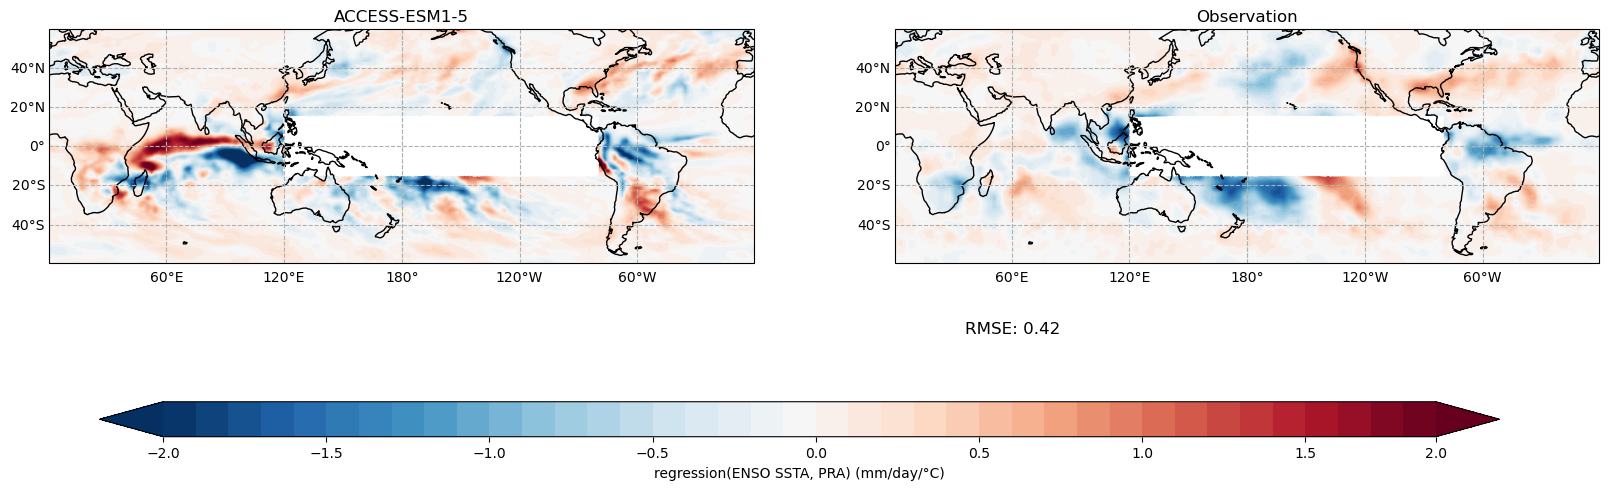

In [33]:
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

fig = plt.figure(figsize=(20, 7))
proj = ccrs.PlateCarree(central_longitude=180)

i =121

for label, cube in process.items():
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(-2,2,0.1), extend='both', cmap='RdBu_r')
    ax1.set_title(label)
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False
    i+=1

plt.text(0.1, -0.3, f'RMSE: {rmse:.2f} ', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Add a single colorbar at the bottom
cax = plt.axes([0.15,0.08,0.7,0.05])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-2,2.5,0.5))
cbar.set_label('regression(ENSO SSTA, PRA) (mm/day/°C)')

## Diagnostics level 2 
el nino, la nina, PRA mm/day

In [19]:
from esmvalcore.preprocessor import mask_above_threshold
from esmvalcore.preprocessor import mask_below_threshold
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import extract_time
import numpy as np

def nino3_4ssta(cube):
    cube = extract_region(cube, 150, 270, -5, 5)
    cube = extract_time(cube, start_year=1979, end_year=2014, start_month=1, end_month=12, start_day=1, end_day=31)
    # triangle weighted- double smoothed
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = area_statistics(cube, 'mean')
    cube = extract_month(cube, 12)
    cube = anomalies(cube, period='monthly')  #normalise?, standardize=True
    return cube
    
def mask_to_years(events):
    maskedTime = np.ma.masked_array(events.coord('time').points, mask=events.data.mask)
    return [events.coord('time').units.num2date(time).year for time in maskedTime.compressed()]
    
def enso_events(cube):
    std = cube.data.std()
    a_events = mask_to_years(mask_above_threshold(cube.copy(), -0.75 * std))
    o_events = mask_to_years(mask_below_threshold(cube.copy(), 0.75 * std))
    return {'nina':a_events, 'nino':o_events}

In [20]:
prep_datasets = {"ACCESS-ESM1-5":[model_pr_datasets_prep["ACCESS-ESM1-5"],model_ts_datasets_prep["ACCESS-ESM1-5"]],
                    'obs':[obs_pr_datasets_prep["GPCP-SG"],obs_ts_datasets_prep["HadISST"]]}

In [21]:
## model
ts_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
), 
"obs":
    Dataset(
    short_name='ts',
    dataset='HadISST',
    mip="Amon",
    project='OBS',
    type='reanaly',
    tier=2)
}

ts_datasets['ACCESS-ESM1-5'].add_supplementary(short_name='areacella', mip='fx')

events_dict = {}
for name, ds in ts_datasets.items(): #ts
    nino_res = nino3_4ssta(ds.load())
    events_dict[name] = enso_events(nino_res) #for each ds?

cubes_dict_nina = {} #collect cubes, dataset(obs,model), enso(nina.nino) - apply to ts and pr preproc
cubes_dict_nino = {}
for ds_name, events in events_dict.items():
    print(ds_name)
    for enso, years in events.items():
        # cube pr and cube ts
        
        year_enso = iris.Constraint(time=lambda cell: cell.point.year in years)
        cube_pr = prep_datasets[ds_name][0].extract(year_enso) # extract from pr cube
        cube_ts = prep_datasets[ds_name][1].extract(year_enso)
        
        if enso == 'nina': ## plot separate
            cubes_dict_nina[ds_name] = [cube_pr, cube_ts]
        else:
            cubes_dict_nino[ds_name] = [cube_pr, cube_ts]

print(events_dict)
for key,val in events_dict.items():
    print(key)
    for k, ls in val.items():
        print(k,len(ls))

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remove_version, more_info)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remove_version, more_info)
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.8/lib/python3.11/site-packages/iris/cube.py:4896: IrisIgnoringBou

ACCESS-ESM1-5
obs
{'ACCESS-ESM1-5': {'nina': [1981, 1984, 1985, 1987, 1990, 1993, 1994, 1999, 2006], 'nino': [1983, 1995, 1997, 1998, 2001, 2004, 2008, 2010, 2012, 2013]}, 'obs': {'nina': [1984, 1988, 1998, 1999, 2007, 2010, 2011], 'nino': [1982, 1986, 1987, 1991, 1994, 1997, 2002, 2006, 2009]}}
ACCESS-ESM1-5
nina 9
nino 10
obs
nina 7
nino 9


In [22]:
process = {} # mask..

# rmse = np.sqrt(np.mean((reg2_obs.data- reg2_mod.data) ** 2))

for key, cubes in cubes_dict_nina.items():
    reg_cube = lin_regress_matrix(cubes[0], cubes[1])
    process[f'{key} la nina DJF'] = mask_pacific(reg_cube)
#rmse ..in plotting.. when even
for key, cubes in cubes_dict_nino.items():
    reg_cube = lin_regress_matrix(cubes[0], cubes[1])
    process[f'{key} el nino DJF'] = mask_pacific(reg_cube)

print(np.sqrt(np.mean((process['obs'].data - process['ACCESS-ESM1-5'].data) ** 2)))

0.6260450527075253


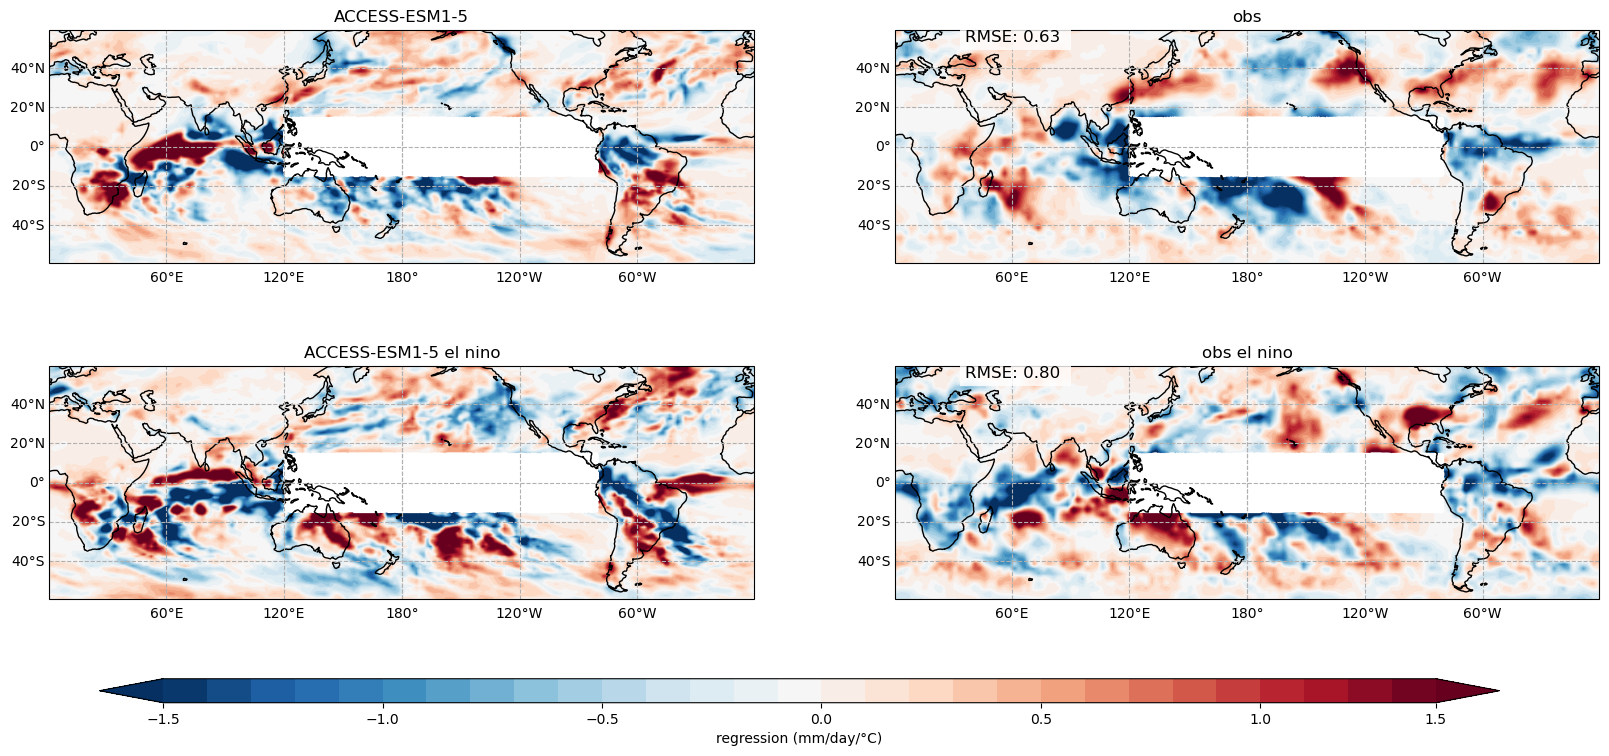

In [23]:
fig = plt.figure(figsize=(20, 8)) #func? params - process, rmse
proj = ccrs.PlateCarree(central_longitude=180)

i =221
for label, cube in process.items(): #j for 2 rows 
    
    ax1 = plt.subplot(i,projection=proj)
    ax1.coastlines()
    cf1 = iplt.contourf(cube, levels=np.arange(-1.5,1.5,0.1), extend='both', cmap='RdBu_r')
    ax1.set_title(label)
    gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
    gl1.top_labels = False
    gl1.right_labels = False
    
    if i%2 == 0: #model first, odd, prev
        rmse = np.sqrt(np.mean((cube.data- cube_prev.data) ** 2))
        plt.text(0.1, 0.95, f'RMSE: {rmse:.2f} ', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    i+=1
    cube_prev = cube
    

cax = plt.axes([0.15,0.01,0.7,0.03])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-1.5,1.8,0.5))
cbar.set_label('regression (mm/day/°C)')